In [1]:
import torch
import requests
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cuda'

In [3]:
Noise_0_dataframe = pd.read_csv("Data/Assignment1/data_0_noise")
Noise_Low_dataframe = pd.read_csv("Data/Assignment1/data_Low_noise")
Noise_High_dataframe = pd.read_csv("Data/Assignment1/data_High_noise")

In [4]:
class_index = list(Noise_0_dataframe["era"].unique())
print(class_index)
def encode(value, class_index = class_index):
    return class_index.index(value)

Noise_0_dataframe["era"] = Noise_0_dataframe["era"].apply(encode)

[2, 4, 5, 7, 9, 10, 12, 15, 16, 18, 19, 21]


## Setting up Dataset & Dataloaders

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, noise, transform=None, target_transform=None,drop = None):
        self.dataframe = dataframe
        if drop != None:
            self.X = dataframe.drop(drop, axis=1).values
        else:
            self.X = dataframe.values
        self.y = dataframe["era"].values
        self.transform = transform
        self.target_transform = target_transform
        self.noise = noise

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item, label = self.X[idx], self.y[idx]
        return item, label

    def get_noise(self):
        return self.noise

In [6]:
Noise_0_dataset = CustomDataset(Noise_0_dataframe, "0",drop = ["row_num","day","era","target_10_val","target_5_val"])
Noise_0_train, Noise_0_test = random_split(Noise_0_dataset, [int(0.8 * len(Noise_0_dataset)), len(Noise_0_dataset) - int(0.8 * len(Noise_0_dataset))])

In [7]:
Noise_0_train_loader = DataLoader(Noise_0_train, batch_size=64, shuffle=True)
Noise_0_test_loader = DataLoader(Noise_0_test, batch_size=64, shuffle=True)

In [8]:
Noise_0_dataframe.head()

,Open_n_val,High_n_val,Low_n_val,Close_n_val,Volume_n_val,SMA_10_val,SMA_20_val,CMO_14_val,High_n-Low_n_val,Open_n-Close_n_val,...,Open_n-Close_n_changelen_val,SMA_20-SMA_10_changelen_val,Close_n_slope_3_changelen_val,Close_n_slope_5_changelen_val,Close_n_slope_10_changelen_val,row_num,day,era,target_10_val,target_5_val
0,0.5,0.5,0.5,0.5,0.0,0.5,0.25,1.0,1.0,0.5,...,0.50,0.75,0.25,0.75,0.50,75,537,0,0.75,0.75
1,0.5,0.5,0.5,0.5,0.0,0.5,0.50,1.0,1.0,0.5,...,0.50,0.50,0.75,0.50,0.50,76,537,0,0.75,0.75
2,0.5,0.5,0.5,0.5,0.0,0.5,0.50,1.0,1.0,0.5,...,0.50,0.25,0.50,0.50,0.75,77,537,0,0.75,0.75
3,0.5,0.5,0.5,0.5,0.0,0.5,0.50,1.0,1.0,0.5,...,0.25,0.25,0.50,0.75,0.50,78,537,0,0.75,0.75
4,0.5,0.5,0.5,0.5,0.0,0.5,0.50,1.0,1.0,0.5,...,0.75,0.25,0.50,0.50,0.50,79,537,0,0.75,0.75


## NAL-MLP

In [9]:
import torch.nn as nn
import torch.nn.init as init

In [10]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, predicted, target):
        loss = torch.mean((predicted - target)**2) 
        return loss

In [161]:
class NAL_MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NAL_MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.att_layer=nn.Linear(hidden_dim,1)
        self.softmax=nn.Softmax()
        self.relu = nn.ReLU()
        self.sigm =nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        y_hat = self.fc2(x)
        y_hat = self.softmax(y_hat)
        h = self.att_layer(x)
        h=  self.sigm(h)
        return y_hat,h

In [187]:
import torch.nn as nn

class CustomLoss(nn.Module):
    def __init__(self,reg,no_of_class=12):
        super(CustomLoss, self).__init__()
        self.reg=reg
        self.no_of_class=12

    def forward(self, inputs, targets):
        p=torch.Tensor(inputs[0]).to(device).t()
        # Converting to 64 X 12 to 64 X 1
        # _,p=torch.max(p,1)
        targets=torch.eye(self.no_of_class).to(device)[targets].t()
        tou=torch.Tensor(inputs[1]).to(device)
        tou=tou.t()
        # print("tou",tou)
        # print(tou)
        loss_a= torch.t(targets)@torch.log(tou*(p-targets)+targets)
        loss_b=self.reg*torch.log(tou)
        loss_a=loss_a.diag().t()
        # print("Loss a",loss_a)
        # print("Loss b",loss_b)
        loss=loss_a+loss_b
        # print("loss",loss.shape)
        # print("return",loss.mean().shape)
        return -loss.mean()

    def custom_p(p):
        return p

In [188]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10,verbose=True):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
            optimizer.zero_grad()
            outputs = model(inputs)
            # print(len(outputs),len(outputs[0]))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs[0], 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs[0], 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

In [189]:
Model = NAL_MLP(24,128,12)
Model = Model.to(device)

In [190]:
optim = optim.Adam(Model.parameters(), lr=0.001, weight_decay=0.001)

C:\temp\ipykernel_18700\2412361404.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(y_hat)


Epoch [1/10], Train Loss: 2.3794, Train Acc: 0.5179, Val Loss: 1.2476, Val Acc: 0.5897
Epoch [2/10], Train Loss: 1.1560, Train Acc: 0.6151, Val Loss: 1.1145, Val Acc: 0.6276
Epoch [3/10], Train Loss: 1.0551, Train Acc: 0.6516, Val Loss: 1.0266, Val Acc: 0.6667
Epoch [4/10], Train Loss: 0.9938, Train Acc: 0.6813, Val Loss: 0.9880, Val Acc: 0.6609
Epoch [5/10], Train Loss: 0.9492, Train Acc: 0.6960, Val Loss: 0.9595, Val Acc: 0.6917
Epoch [6/10], Train Loss: 0.9197, Train Acc: 0.7093, Val Loss: 0.9325, Val Acc: 0.7135
Epoch [7/10], Train Loss: 0.8864, Train Acc: 0.7199, Val Loss: 0.8919, Val Acc: 0.7231
Epoch [8/10], Train Loss: 0.8573, Train Acc: 0.7421, Val Loss: 0.8628, Val Acc: 0.7026
Epoch [9/10], Train Loss: 0.8312, Train Acc: 0.7457, Val Loss: 0.8394, Val Acc: 0.7231
Epoch [10/10], Train Loss: 0.8107, Train Acc: 0.7446, Val Loss: 0.8179, Val Acc: 0.7571


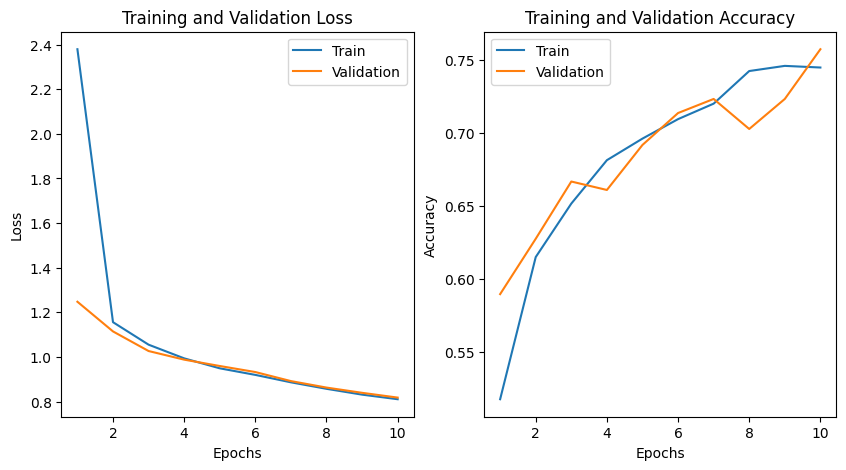

In [192]:
train_model(Model,CustomLoss(50,no_of_class=12), optim,Noise_0_train_loader, Noise_0_test_loader,num_epochs=10)

In [58]:
temp=np.ones([12,64])
tou=np.ones([64,1]).T
tou[0,3]=22
tou.shape

(1, 64)

In [62]:
(tou*temp)[:,3]

array([22., 22., 22., 22., 22., 22., 22., 22., 22., 22., 22., 22.])